In [1]:
import shap
import datetime
import numpy as np
import pandas as pd
import multiprocessing as mp
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

In [2]:
FREQ = "15 min"

Generate synthetic dataset

In [3]:
def get_test_data(
    n_features=40, n_informative=10, n_redundant=10, n_samples=10000, n_classes=2, weights=[0.5, 0.5], shuffle=True
): 
    
    # generate a random dataset for a classification problem
    from sklearn.datasets import make_classification

    trnsX, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_informative,
        n_redundant=n_redundant,
        shuffle=shuffle,
        n_classes=n_classes,
        weights=weights
    )
    df = pd.date_range(periods=n_samples, end=pd.datetime.today(), freq=FREQ)
    df0 = pd.DatetimeIndex(df)
    trnsX, y = pd.DataFrame(trnsX, index=df0), pd.Series(y, index=df0)
    df0 = ["I_" + str(i) for i in range(n_informative)] + ["R_" + str(i) for i in range(n_redundant)]
    df0 += ["N_" + str(i) for i in range(n_features - len(df0))]
    trnsX.columns = df0
    
    return trnsX, y

In [10]:
X, y = get_test_data(
    n_features=12, n_informative=2, n_redundant=3, n_samples=1000, weights=[0.5, 0.5], shuffle=False
)
X.head()

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


,I_0,I_1,R_0,R_1,R_2,N_0,N_1,N_2,N_3,N_4,N_5,N_6
2022-02-09 00:26:31.258895,-2.355075,-0.727592,-1.498947,2.243175,2.197179,-0.130928,1.597208,0.222531,-0.224505,-2.480466,0.754731,0.792801
2022-02-09 00:41:31.258895,-2.184162,-2.001167,-2.467107,2.461487,2.247037,-1.770554,-0.084450,-0.894881,0.802951,0.449746,-0.907132,-2.065689
2022-02-09 00:56:31.258895,0.542875,-0.468585,-0.171116,-0.334252,-0.406064,-0.639463,0.878486,0.689437,-1.846508,-1.003376,0.574308,1.034247
2022-02-09 01:11:31.258895,-0.470072,-0.928037,-0.934786,0.672660,0.562090,-0.415045,1.202658,-0.164866,-0.271996,0.245960,0.023903,0.523562
2022-02-09 01:26:31.258895,-1.357677,-1.153655,-1.460260,1.504125,1.382515,-0.231987,-0.725749,-0.301231,-0.624878,0.969561,0.512013,0.615521


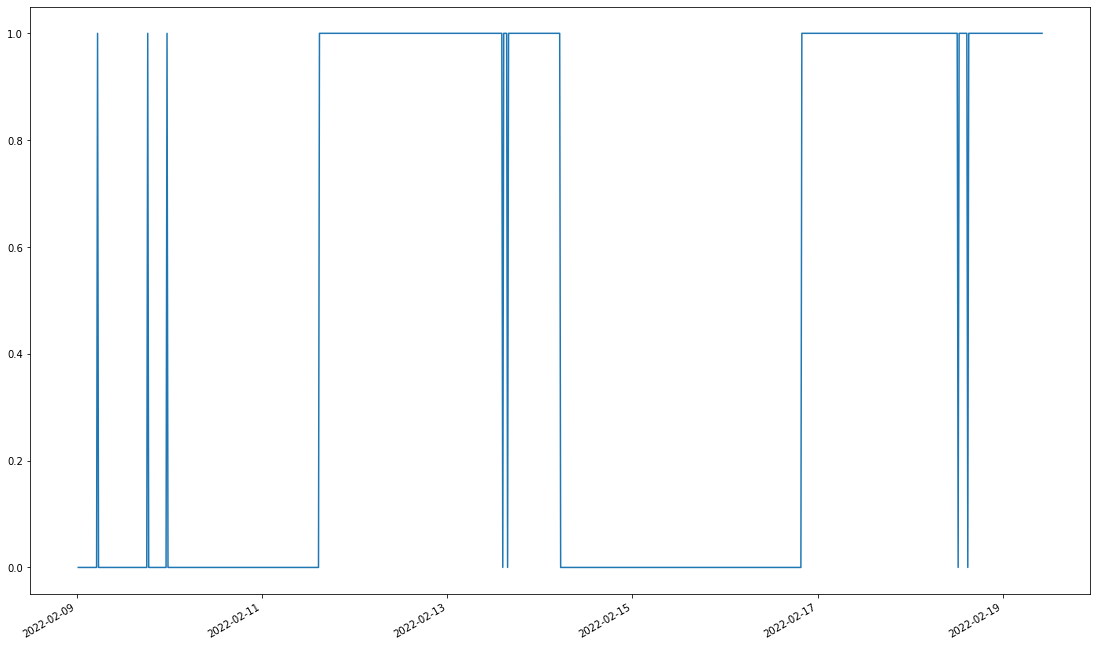

In [11]:
y.plot(figsize=(19, 12));

Traine LGBMClassifier for our dataset

In [12]:
model = LGBMClassifier()

In [13]:
skf = StratifiedKFold(n_splits=10)

In [14]:
scores = []
fold = 1
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_pred, y_test)
    print("FOLD:", fold, "SCORE:", f1)
    fold += 1
    scores.append(f1)        

FOLD: 1 SCORE: 0.9462365591397849
FOLD: 2 SCORE: 1.0
FOLD: 3 SCORE: 1.0
FOLD: 4 SCORE: 0.99009900990099
FOLD: 5 SCORE: 0.9411764705882353
FOLD: 6 SCORE: 0.7878787878787878
FOLD: 7 SCORE: 0.8910891089108911
FOLD: 8 SCORE: 0.7835051546391754
FOLD: 9 SCORE: 0.78
FOLD: 10 SCORE: 0.7157894736842104


In [15]:
np.mean(scores)

0.8835774564742076

## Feature Imprortance with SHAP

The Shapley value is a solution concept in cooperative game theory. It was named in honor of Lloyd Shapley, who introduced it in 1951 and won the Nobel Prize in Economics for it in 2012. To each cooperative game it assigns a unique distribution (among the players) of a total surplus generated by the coalition of all players. The Shapley value is characterized by a collection of desirable properties. Hart (1989) provides a survey of the subject.
The setup is as follows: a coalition of players cooperates, and obtains a certain overall gain from that cooperation. Since some players may contribute more to the coalition than others or may possess different bargaining power (for example threatening to destroy the whole surplus), what final distribution of generated surplus among the players should arise in any particular game? Or phrased differently: how important is each player to the overall cooperation, and what payoff can he or she reasonably expect? The Shapley value provides one possible answer to this question.
For cost-sharing games with concave cost functions, the optimal cost-sharing rule that optimizes the price of anarchy, followed by the price of stability, is precisely the Shapley value cost-sharing rule.(A symmetrical statement is similarly valid for utility-sharing games with convex utility functions.) In mechanism design, this means that the Shapley value solution concept is optimal for these sets of games.

The formula of calculating Shapley value for the i-th feature:
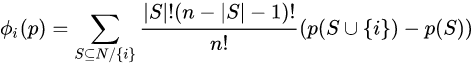
P(S U {i}) - prediction of the model with the i-th feature,

P(S) - model prediction without the i-th feature,

n - number of features,

S - random set of features without the i-th feature

In [16]:
explainer = shap.TreeExplainer(model)
expected_value = explainer.expected_value

In [17]:
shap_values = shap.TreeExplainer(model).shap_values(X_train)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Plot of SHAP values for each feature to identify how much impact each feature has on the model output in the train dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples.

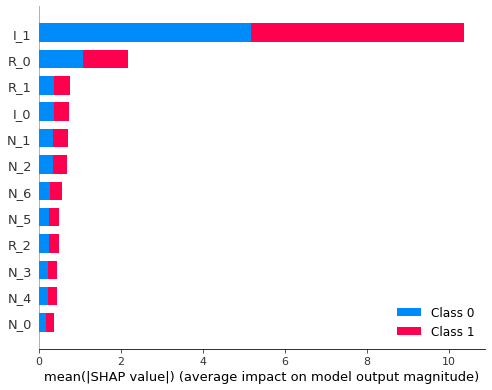

In [18]:
shap.summary_plot(shap_values, X_train, plot_type='bar')

In [19]:
expected_value

array([0.26767771])

In [20]:
shap_values[0].shape

(900, 12)

Summary plot of SHAP values for test dataset

In [21]:
shap_values = shap.TreeExplainer(model).shap_values(X_test)

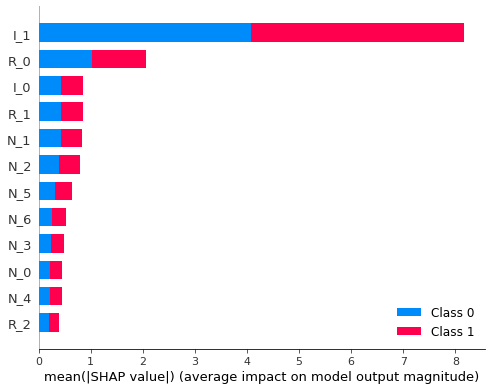

In [22]:
shap.summary_plot(shap_values, X_test, plot_type='bar')

 This shows that importance of features for train and test dataset are slightly different. And this must be taken into account.

In [23]:
expected_value

array([0.26767771])

Each observation’s prediction is represented by a colored line. At the top of the plot, each line strikes the x-axis at its corresponding observation’s predicted value. This value determines the color of the line on a spectrum. * Moving from the bottom of the plot to the top, SHAP values for each feature are added to the model’s base value. This shows how each feature contributes to the overall prediction. * At the bottom of the plot, the observations converge at explainer.expected_value.

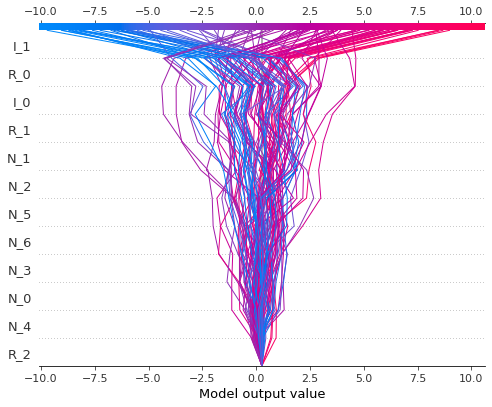

In [24]:
shap.decision_plot(expected_value[0], shap_values[0], X_test, ignore_warnings=True)

SHAP Interaction Values

SHAP interaction values are a generalization of SHAP values to higher order interactions. Fast exact computation of pairwise interactions are implemented for tree models. This returns a matrix for every prediction, where the main effects are on the diagonal and the interaction effects are off-diagonal. 

In [25]:
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X_test)

Interaction - a summary:

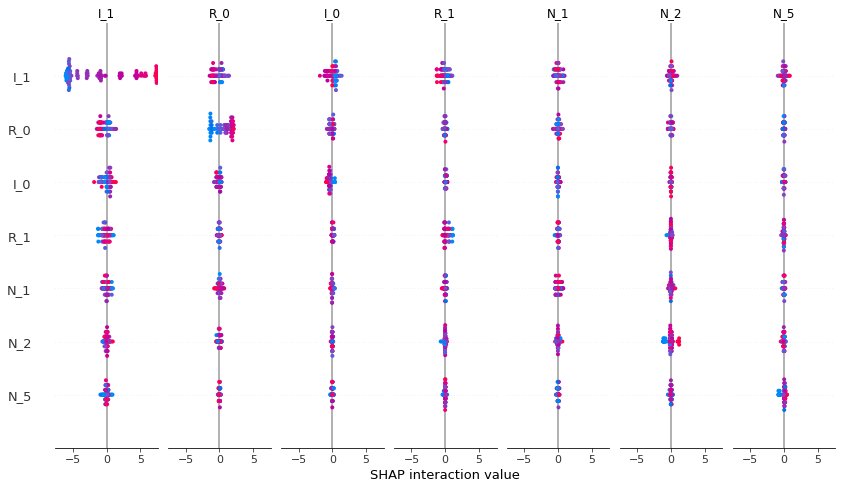

In [26]:
shap.summary_plot(shap_interaction_values, X_test)

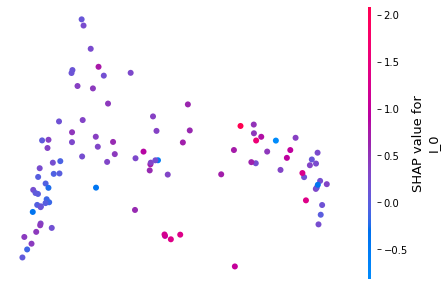

In [30]:
shap.embedding_plot(0, shap_values[0], feature_names=X.columns)

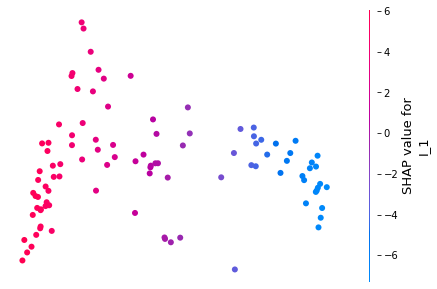

In [31]:
shap.embedding_plot(1, shap_values[0], feature_names=X.columns)

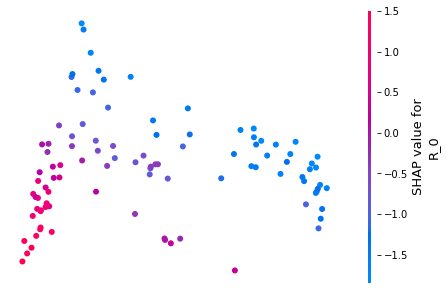

In [33]:
shap.embedding_plot(2, shap_values[0], feature_names=X.columns)

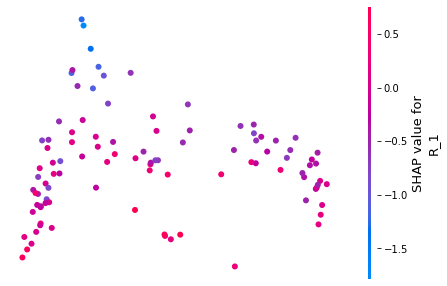

In [34]:
shap.embedding_plot(3, shap_values[0], feature_names=X.columns)

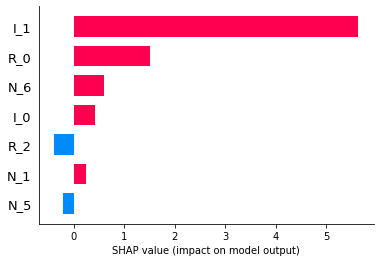

In [36]:
shap.bar_plot(shap_values[0][0], feature_names=X.columns)

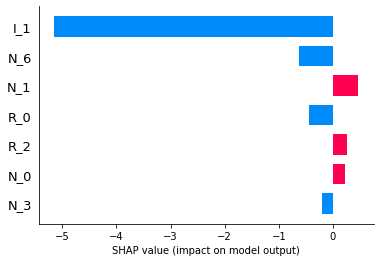

In [37]:
shap.bar_plot(shap_values[1][1], feature_names=X.columns)

SHAP Dependence Plots

SHAP dependence plots show the effect of a single feature across the whole dataset.

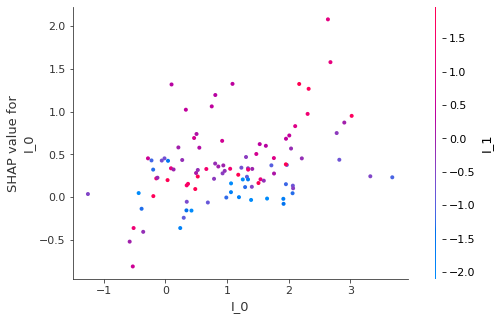

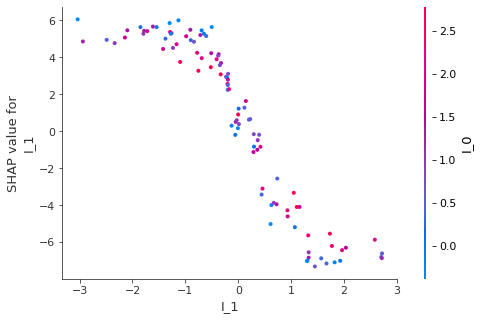

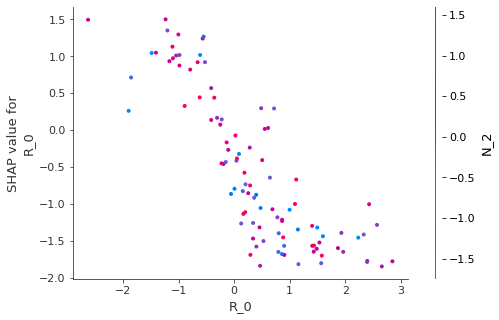

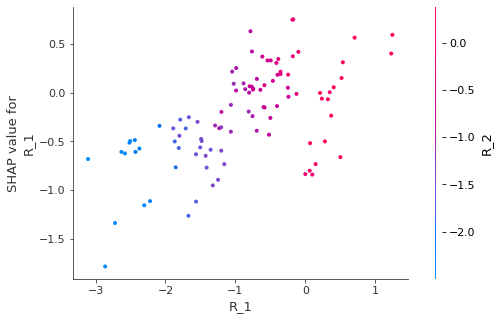

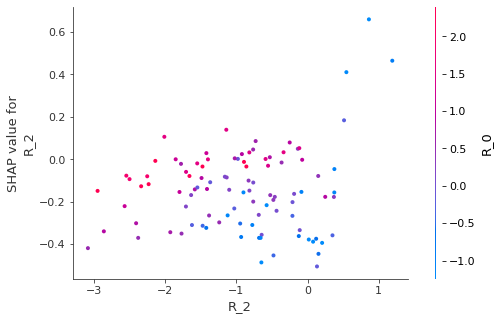

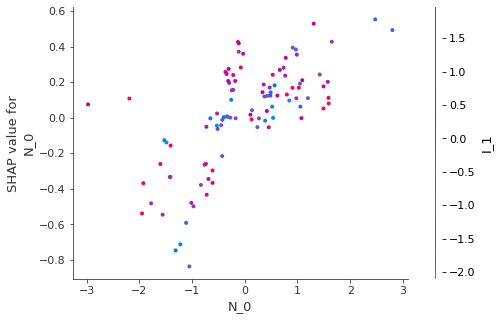

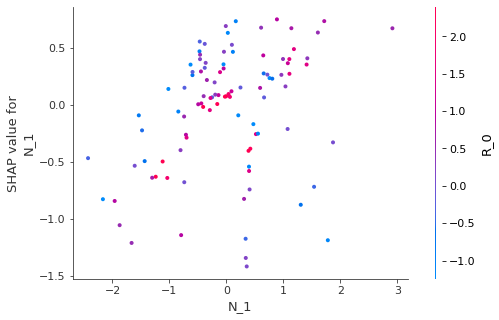

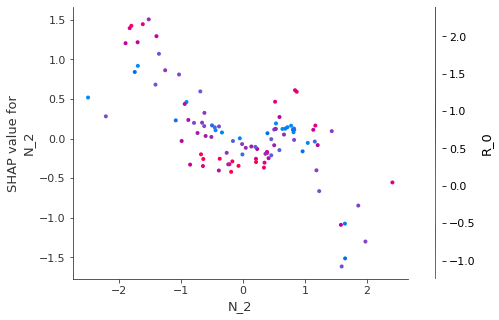

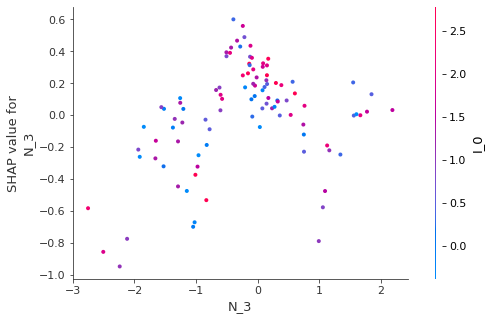

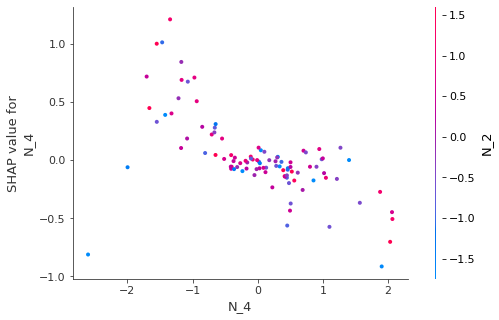

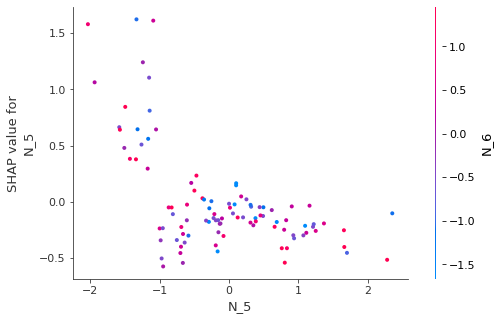

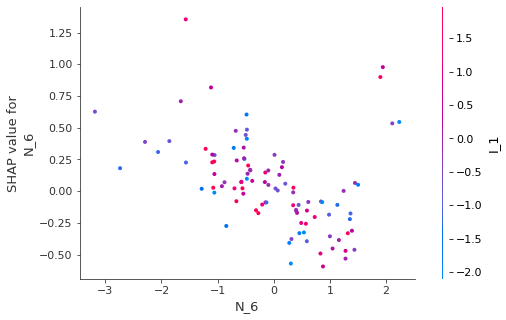

In [38]:
for i in range(0, len(X.columns)):
    shap.dependence_plot(i, shap_values[0], X_test)

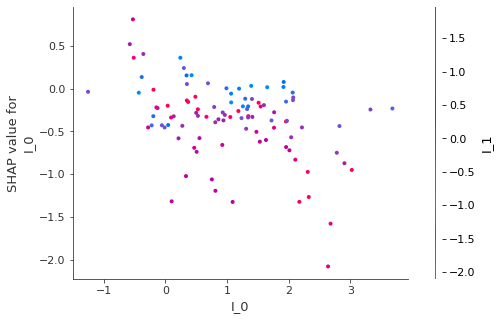

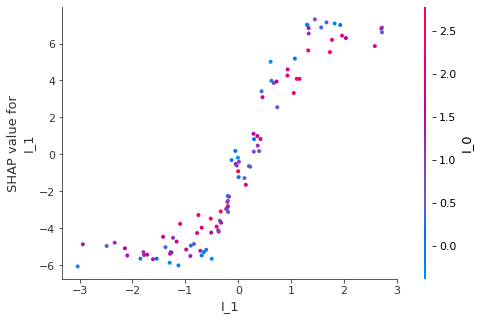

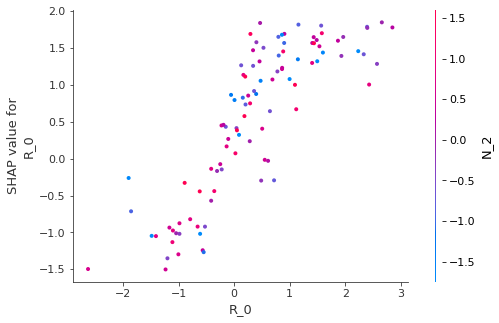

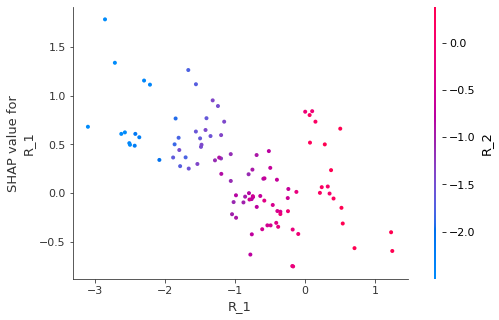

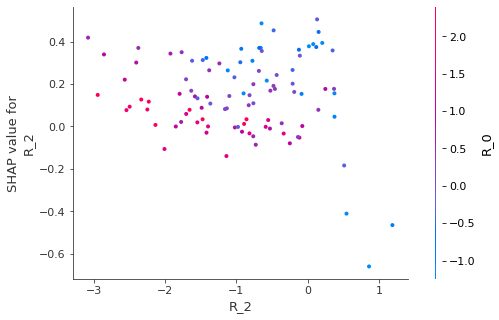

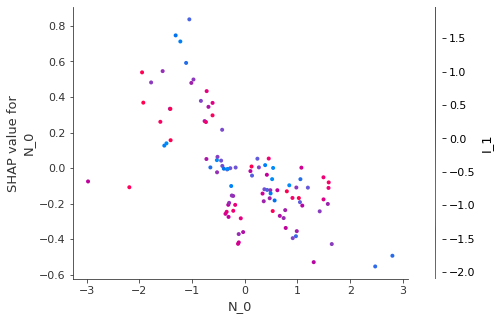

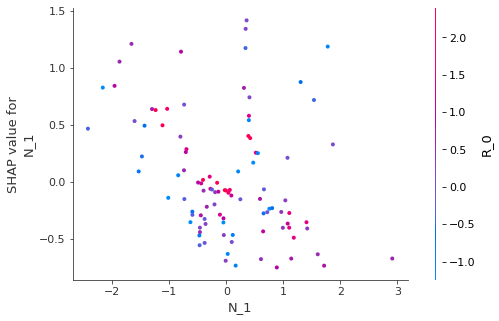

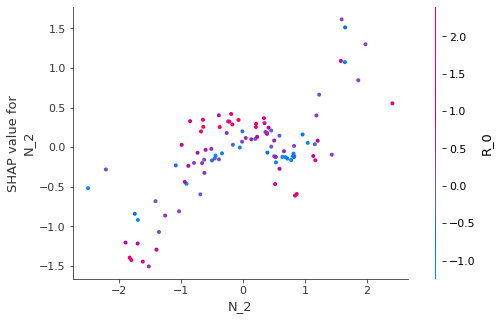

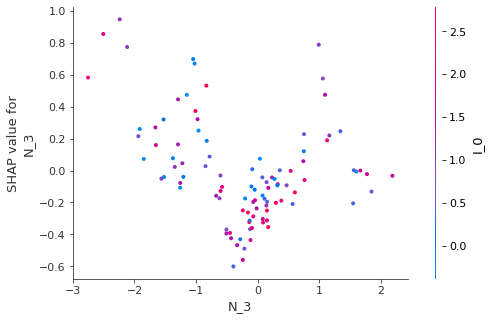

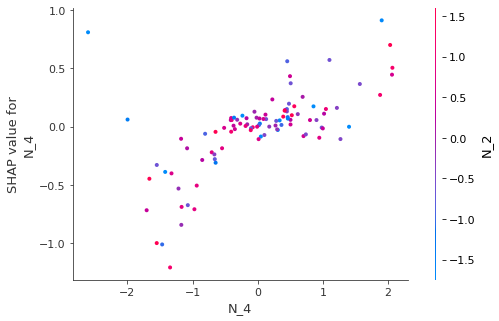

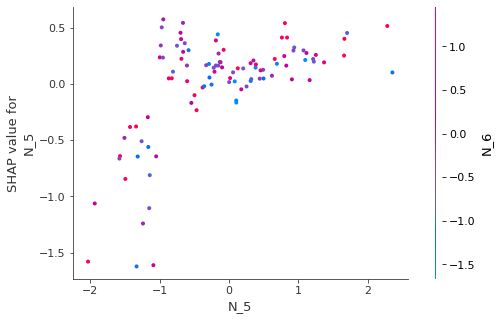

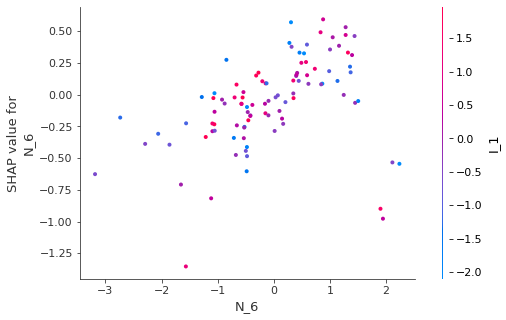

In [39]:
for i in range(0, len(X.columns)):
    shap.dependence_plot(i, shap_values[1], X_test)